In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import scipy
import tensorflow as tf
import dcor
from typing import List
import plotly.express as px
from sklearn.cluster import KMeans
import sklearn 

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import plotly.io as pio
pio.renderers.default = "iframe"
plt.ioff()

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
np.random.seed(0)

In [5]:
# Load dataset 
bone_marrow_transplant_children = fetch_ucirepo(id=565) 

# data (as pandas dataframes) 
X = bone_marrow_transplant_children.data.features 
y = bone_marrow_transplant_children.data.targets 

In [6]:
df = pd.concat([X, y], axis=1)

## Preprocessing

### Missing data analysis

In [7]:
print('Number of missing values for each feature of the dataset')
df.isna().sum()

Number of missing values for each feature of the dataset


Recipientgender          0
Stemcellsource           0
Donorage                 0
Donorage35               0
IIIV                     0
Gendermatch              0
DonorABO                 0
RecipientABO             1
RecipientRh              2
ABOmatch                 1
CMVstatus               16
DonorCMV                 2
RecipientCMV            14
Disease                  0
Riskgroup                0
Txpostrelapse            0
Diseasegroup             0
HLAmatch                 0
HLAmismatch              0
Antigen                  1
Allele                   1
HLAgrI                   0
Recipientage             0
Recipientage10           0
Recipientageint          0
Relapse                  0
aGvHDIIIIV               0
extcGvHD                31
CD34kgx10d6              0
CD3dCD34                 5
CD3dkgx10d8              5
Rbodymass                2
ANCrecovery              0
PLTrecovery              0
time_to_aGvHD_III_IV     0
survival_time            0
survival_status          0
d

Three features have many missing values (CMVstatus, RecipientCMV and extcGvHD). Later in our analysis, CMVstatus will be removed. We are therefore only concerned with RecipientCMV and extcGvHD. We replace the nans in these features with a "Missing" flag to retain this information if it plays a role in the individual's survival time. 

As the other features contain few missing values, we then delete the patients whose data is incomplete so as not to complicate the problem. 

In [8]:
df['extcGvHD'] = df['extcGvHD'].replace({np.nan : 'Missing'})
df['RecipientCMV'] = df['RecipientCMV'].replace({np.nan : 'Missing'})
df['CMVstatus'] = df['CMVstatus'].replace({np.nan : 'Missing'})

In [9]:
len(df)

187

In [10]:
df = df.dropna()

In [11]:
len(df)

177

### One hot encoding

In [12]:
def get_one_hot_encoded_df(df: pd.DataFrame, features_to_encode: List[str]) -> pd.DataFrame:
    # Extract object type columns from the df (in our dataset, there is only Disease column)
    one_hot_encoded_features = []
    for feature in features_to_encode:
        feature_col = df[feature]

        # if feature is DonorABO or RecipientABO we change the values of the column for more clarity
        if feature in ['DonorABO', 'RecipientABO']:
            feature_col = feature_col.replace({0: 'O', 1: 'A', -1: 'B', 2: 'AB'})
        if feature in ['Allele', 'Antigen']:
            feature_col = feature_col.replace({-1: 'No_diff', 0: 'One_diff', 1: 'Two_diff', 2: 'Three_diff', 3: 'Four_diff'})
        if feature == 'HLAgrI':
            # According to the description of the feature, there seems to be an inconsistency, as 4 and 5 represent the same thing
            # Also, in the data we find rows where HLAgrI is equal to 7 which is not mentionned in the description, we can suppose that it means 4
            feature_col = feature_col.replace({5:4, 7:4})
    
        # One hot encode feature 
        one_hot_encoded = pd.get_dummies(feature_col).astype(float)
        one_hot_encoded = one_hot_encoded.rename(columns={c: feature + '_' + str(c) for c in one_hot_encoded.columns})
        one_hot_encoded_features.append(one_hot_encoded)

    df = df.drop(features_to_encode, axis=1)
    one_hot_encoded_features.append(df)
    # Recombine the dataset
    df = pd.concat(one_hot_encoded_features, axis=1)

    return df

In [13]:
df = get_one_hot_encoded_df(df, features_to_encode=['Disease', 'DonorABO', 'RecipientABO', 'Allele', 'Antigen', 'HLAgrI', 'CMVstatus', 'extcGvHD', 'RecipientCMV', 'HLAmatch'])

In [14]:
df

,Disease_ALL,Disease_AML,Disease_chronic,Disease_lymphoma,Disease_nonmalignant,DonorABO_A,DonorABO_AB,DonorABO_B,DonorABO_O,RecipientABO_A,RecipientABO_AB,RecipientABO_B,RecipientABO_O,Allele_Four_diff,Allele_No_diff,Allele_One_diff,Allele_Three_diff,Allele_Two_diff,Antigen_No_diff,Antigen_One_diff,Antigen_Three_diff,Antigen_Two_diff,HLAgrI_0,HLAgrI_1,HLAgrI_2,HLAgrI_3,HLAgrI_4,CMVstatus_0.0,CMVstatus_1.0,CMVstatus_2.0,CMVstatus_3.0,CMVstatus_Missing,extcGvHD_0.0,extcGvHD_1.0,extcGvHD_Missing,RecipientCMV_0.0,RecipientCMV_1.0,RecipientCMV_Missing,HLAmatch_0,HLAmatch_1,HLAmatch_2,HLAmatch_3,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,RecipientRh,ABOmatch,DonorCMV,Riskgroup,Txpostrelapse,Diseasegroup,HLAmismatch,Recipientage,Recipientage10,Recipientageint,Relapse,aGvHDIIIIV,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,22.830137,0,1,0,1.0,0.0,1.0,1,0,1,0,9.6,0,1,0,0,7.20,1.338760,5.38,35.0,19,51,32,999,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,23.342466,0,1,0,1.0,0.0,0.0,0,0,1,0,4.0,0,0,1,1,4.50,11.078295,0.41,20.6,16,37,1000000,163,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0,26.394521,0,1,0,1.0,0.0,0.0,0,0,1,0,6.6,0,1,1,1,7.94,19.013230,0.42,23.4,23,20,1000000,435,1
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,39.684932,1,1,0,1.0,1.0,1.0,0,0,1,0,18.1,1,2,0,0,4.25,29.481647,0.14,50.0,23,29,19,53,1
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1,33.358904,0,0,0,0.0,1.0,0.0,1,0,1,0,1.3,0,0,0,1,51.85,3.972255,13.05,9.0,14,14,1000000,2043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,37.632877,1,0,0,1.0,1.0,1.0,1,0,1,0,8.8,0,1,0,1,12.58,2.426122,5.19,33.0,1000000,1000000,1000000,6,1
182,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1,37.575342,1,1,0,0.0,0.0,1.0,1,1,1,0,12.9,1,2,1,0,11.08,2.522750,4.39,44.0,15,22,16,385,1
183,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1,22.895890,0,0,0,1.0,1.0,0.0,1,0,1,0,13.9,1,2,0,1,4.64,1.038858,4.47,44.5,12,30,1000000,634,1
184,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1,27.347945,0,1,0,1.0,1.0,1.0,0,0,0,0,10.4,1,2,0,1,7.73,1.635559,4.73,33.0,16,16,1000000,1895,0


## Correlation analysis

We will now study the correlations between the patients' features. 

We consider two types of features, categorical features and continuous features. 

To quantify the correlation between continuous features we will use Pearson's correlation, between categorical and continuous features we will use the point biserial correlation and between categorical features we will use Cramer's v correlation.

In [15]:
def cramers_v(var1, var2):
    data = pd.crosstab(var1, var2).values
    chi_2 = scipy.stats.chi2_contingency(data)[0]
    n = data.sum()
    phi_2 = chi_2 / n
    r, k = data.shape
    return np.sqrt(phi_2 / min((k-1), (r-1)))

In [16]:
def show_correlation(corrs_matrix: List[List[float]],
                     x_labels: List[str],
                     y_labels: List[str],
                     min_value: int,
                     max_value: int
                    ) -> tuple[np.ndarray[np.ndarray], np.ndarray]:
    
    # Create custom color bar
    if min_value == 0:
        clist = [(0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
        cmap = LinearSegmentedColormap.from_list("custom_black_orange", clist)
    elif min_value == -1:
        clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
        cmap = LinearSegmentedColormap.from_list("custom_blue_black_orange", clist)

    # Reorder correlation values based on a hierarchical clustering so that features higly correlated are close in the correlation matrix
    # for easier analysis
    if x_labels == y_labels:
        feature_linkage_matrix = scipy.cluster.hierarchy.linkage(corrs_matrix)
        sort_dendrogram = scipy.cluster.hierarchy.dendrogram(feature_linkage_matrix, 
                                                             count_sort="ascending", 
                                                             color_threshold=0,
                                                             no_plot=True)
        ordering = sort_dendrogram["leaves"]
        # Sort correlations according to the computed order and add survival_time correlations as the last column/row of the reordered matrix
        corrs_matrix = np.array(corrs_matrix)[ordering][:, ordering]
        x_labels = np.array(x_labels)[ordering]
        y_labels = np.array(y_labels)[ordering]
                                
    plt.figure(figsize=(15,15))
        
    ax = sns.heatmap(corrs_matrix,
                     linewidth=0.5,
                     vmin=min_value,
                     vmax=max_value,
                     xticklabels=x_labels,
                     yticklabels=y_labels,
                     cmap=cmap)
    
    plt.show()

    return pd.DataFrame(data=corrs_matrix, index=y_labels, columns=x_labels)
    

The following function, given the dataframe and the list of continuous and categorical features outputs three correlation matrix (for continuous-continuous, continuous-categorical and categorical-categorical features correlations).

In [17]:
def generate_correlation_matrices(df: pd.DataFrame,
                                  continuous_features: List[str],
                                  categorical_features: List[str],
                                  ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    continuous_continuous_corrs = []
    continous_categorical_corrs = []
    categorical_categorical_corrs = []

    # Pearson correlations between continuous variables
    for cont_1 in continuous_features:
        continuous_continuous_corrs_i = []
        for cont_2 in continuous_features:
            if (cont_1 == 'survival_time') or (cont_2 == 'survival_time'):
                # We only consider non censored data if survival_time is involved in correlation
                df_death = df[df.survival_status == 1]
                continuous_values_1 = df_death[cont_1].astype(float)
                continuous_values_2 = df_death[cont_2].astype(float) 
                
            else:
                continuous_values_1 = df[cont_1].astype(float)
                continuous_values_2 = df[cont_2].astype(float)
            continuous_continuous_corrs_i.append(scipy.stats.pearsonr(continuous_values_1, continuous_values_2).statistic)
        continuous_continuous_corrs.append(continuous_continuous_corrs_i)

    cont_cont_corrs_df = show_correlation(continuous_continuous_corrs,
                                          x_labels=continuous_features,
                                          y_labels=continuous_features,
                                          min_value=-1,
                                          max_value=1)

    # Point biserial correlation between continuous and categorical features
    for cont in continuous_features:
        continous_categorical_corrs_i = []
        for cat in categorical_features:
            if cont == 'survival_time':
                # We only consider non censored data when survival_time is involved in the correlation
                df_death = df[df.survival_status == 1]
                continuous_values = df_death["survival_time"].astype(float)
                categorical_values = df_death[cat].astype(float) 
                
            else:
                continuous_values = df[cont].astype(float)
                categorical_values = df[cat].astype(float)
            continous_categorical_corrs_i.append(scipy.stats.pointbiserialr(continuous_values, categorical_values).statistic)
        continous_categorical_corrs.append(continous_categorical_corrs_i)

    
    cont_cat_corrs_df = show_correlation(continous_categorical_corrs,
                                         x_labels=categorical_features,
                                         y_labels=continuous_features,
                                         min_value=-1,
                                         max_value=1)

    # Cramer's v correlation between categorical features
    for cat_1 in categorical_features:
        categorical_categorical_corrs_i = []
        for cat_2 in categorical_features:
            categorical_categorical_corrs_i.append(cramers_v(df[cat_1].astype(float), df[cat_2].astype(float)))
        categorical_categorical_corrs.append(categorical_categorical_corrs_i)

    
    cat_cat_corrs_df = show_correlation(categorical_categorical_corrs,
                                        x_labels=categorical_features,
                                        y_labels=categorical_features,
                                        min_value=0,
                                        max_value=1)
    
    return (cont_cont_corrs_df,
            cont_cat_corrs_df,
            cat_cat_corrs_df)
    

In [18]:
categorical_features = list(df.columns[df.isin([0,1]).all()])
categorical_features.remove('survival_status')

continuous_features = ['Donorage', 'Recipientage', 'CD34kgx10d6', 'CD3dCD34', 'CD3dkgx10d8', 'Rbodymass', 'ANCrecovery', 'PLTrecovery', 'time_to_aGvHD_III_IV', 'survival_time']

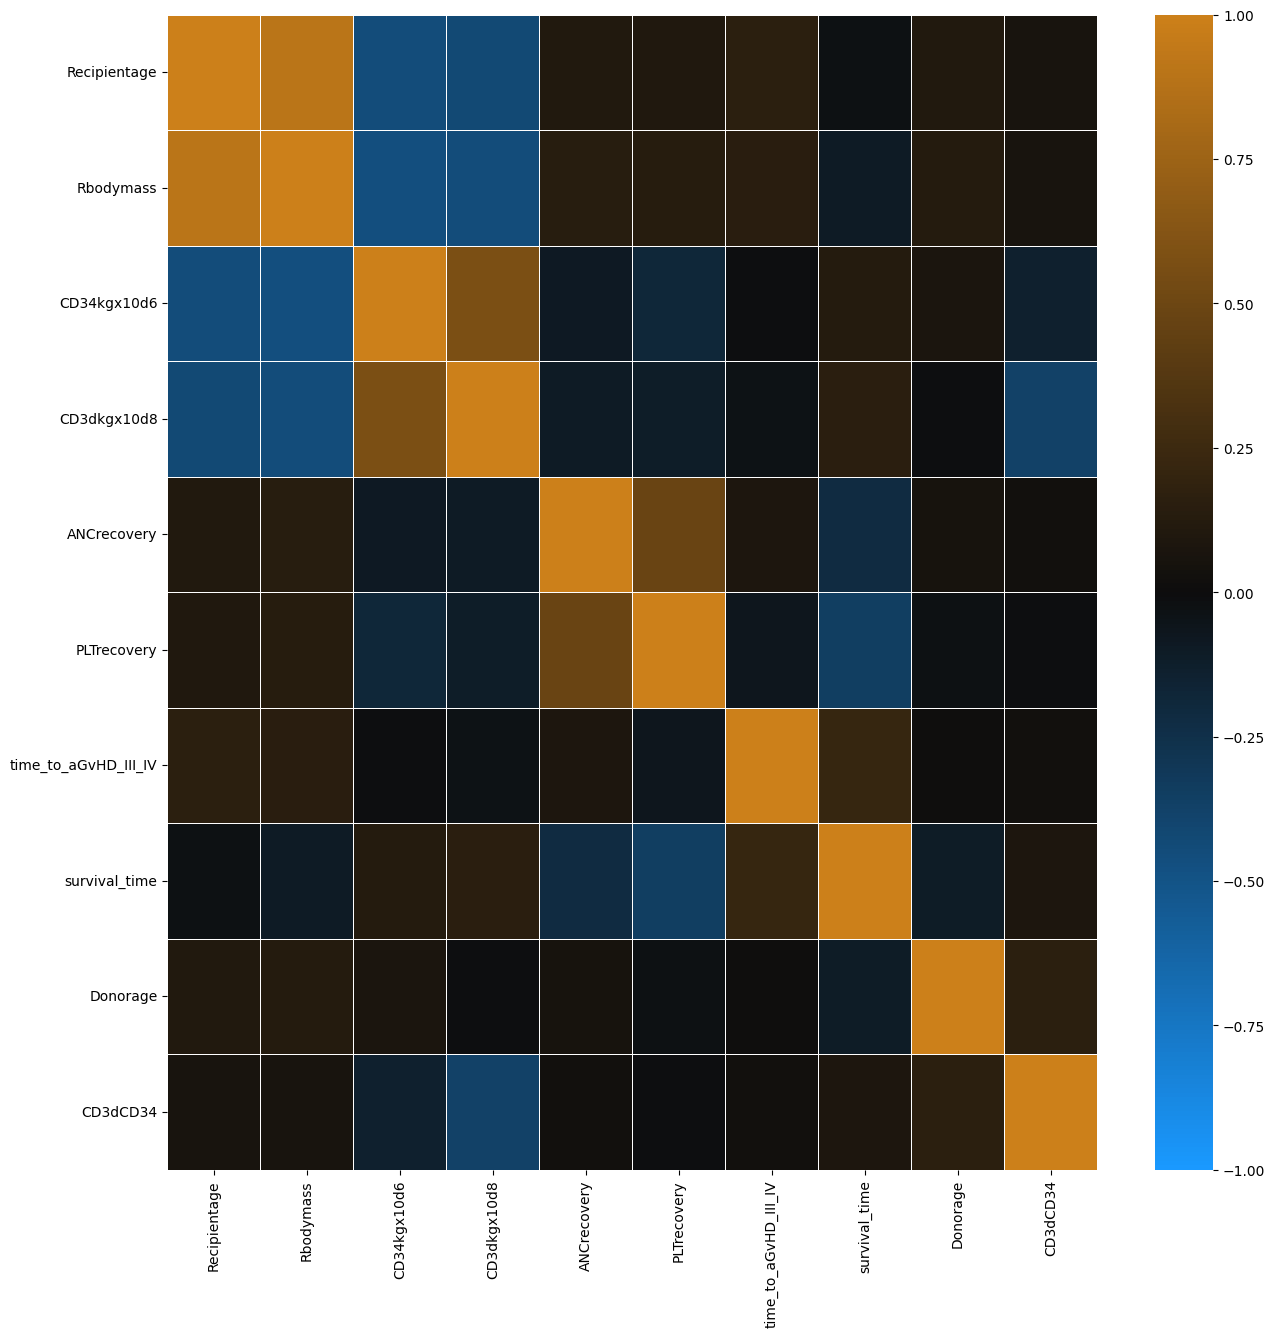

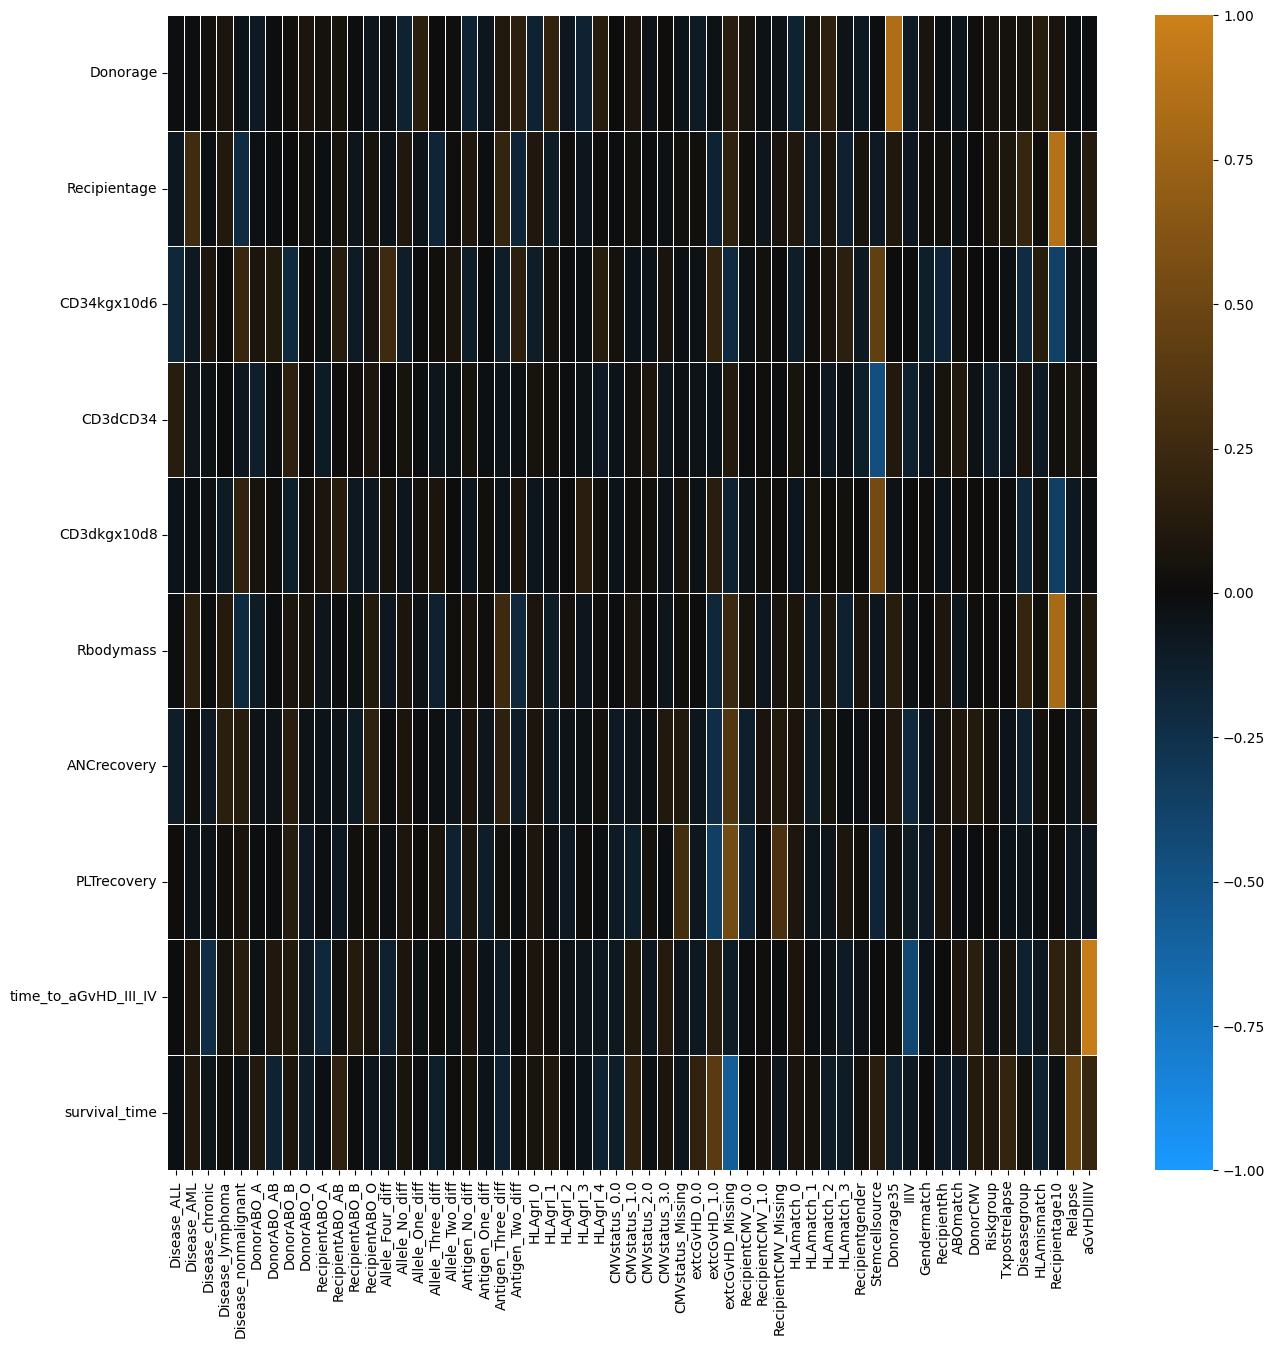

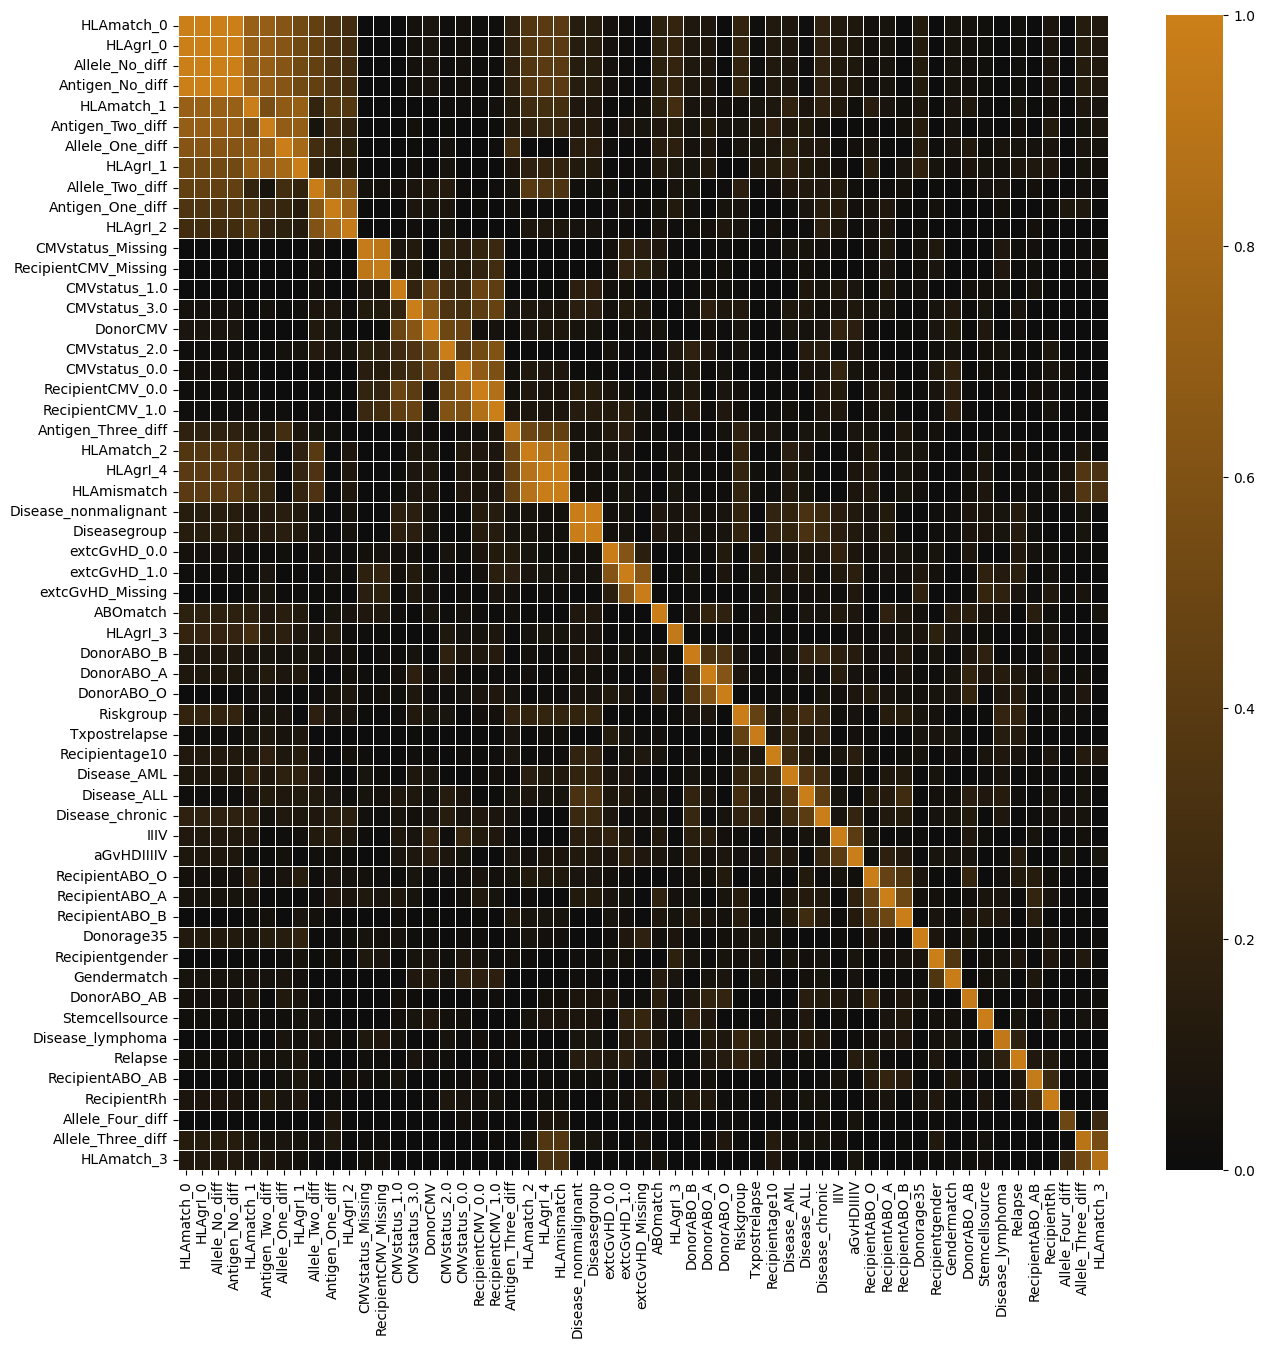

In [19]:
cont_cont_corrs_df, cont_cat_corrs_df, cat_cat_corrs_df = generate_correlation_matrices(df, continuous_features, categorical_features)
                              

In [20]:
cat_cat_corrs_df.columns

Index(['HLAmatch_0', 'HLAgrI_0', 'Allele_No_diff', 'Antigen_No_diff',
       'HLAmatch_1', 'Antigen_Two_diff', 'Allele_One_diff', 'HLAgrI_1',
       'Allele_Two_diff', 'Antigen_One_diff', 'HLAgrI_2', 'CMVstatus_Missing',
       'RecipientCMV_Missing', 'CMVstatus_1.0', 'CMVstatus_3.0', 'DonorCMV',
       'CMVstatus_2.0', 'CMVstatus_0.0', 'RecipientCMV_0.0',
       'RecipientCMV_1.0', 'Antigen_Three_diff', 'HLAmatch_2', 'HLAgrI_4',
       'HLAmismatch', 'Disease_nonmalignant', 'Diseasegroup', 'extcGvHD_0.0',
       'extcGvHD_1.0', 'extcGvHD_Missing', 'ABOmatch', 'HLAgrI_3',
       'DonorABO_B', 'DonorABO_A', 'DonorABO_O', 'Riskgroup', 'Txpostrelapse',
       'Recipientage10', 'Disease_AML', 'Disease_ALL', 'Disease_chronic',
       'IIIV', 'aGvHDIIIIV', 'RecipientABO_O', 'RecipientABO_A',
       'RecipientABO_B', 'Donorage35', 'Recipientgender', 'Gendermatch',
       'DonorABO_AB', 'Stemcellsource', 'Disease_lymphoma', 'Relapse',
       'RecipientABO_AB', 'RecipientRh', 'Allele_Four_diff'

### Correlation matrix analysis

The correlation matrix shows that several groups of features are highly correlated. We will remove some features to ease the convergence of the models.

### a) Continuous-continuous correlations

- <b> Recipientage, Rbodymass, CD34kgx10d6 and CD3dkgx10d8 </b>: These 4 features are quite strongly correlated. We keep only CD34kgx10d6.

- <b> ANCrecovery and PLTrecovery </b>: are also highly correlated. We keep only ANCrecovery.



In [21]:
df = df.drop(['PLTrecovery', 'CD3dkgx10d8', 'Rbodymass', 'Recipientage'], axis=1)

### b) Continuous-categorical correlations

- <b> Donorage and Donorage35 </b>: The Donorage35 feature is worth 1 when Donorage > 35 and 0 otherwise. These two features are therefore redundant. Donorage35 can be removed from the dataset.

- <b> Recipientage10 and Recipientage </b>: same principle. We only keep Recipientage.

- <b> CD3dCD34 and Stemcellsource </b>: these two features are higly correlated. We only keep Stemcellsource as CD3dCD34 is highly redundant with CD34kgx10d6 and CD3dkgx10d8.


In [22]:
df = df.drop(['Donorage35', 'Recipientage10', 'CD3dCD34'], axis=1)

### c) Categorical-categorical correlations
We ignore high correlations between one hot encoded features that come from the same original feature.

-  <b> Allele_Two_diff, Antigen_One_diff, HLAgrI_2 </b>: these three features have very high one-to-one correlation. We keep only Allele_Two_diff.

- <b> Allele_No_diff, Antigen_No_diff, HLAgrI_0, HLAgrI_1, Allele_One_diff, Antigen_Two_diff, HLAmismatch</b> : They are highly correlated. Moreover Allele_No_diff, Antigen_No_diff, HLAgrI_0 means the same thing. We can only keep HLAgrI_0.

-  <b> RecipientCMV_Missing and CMVstatus_Missing </b> : these features means the same thing in this dataset, we remove CMVstatus_Missing.

- <b> HLAgrI_4 and HLAmismatch </b> : these two features are highly correlated, we keep HLAmismatch.

- <b> Disease_nonmalignant, Diseasegroup </b> : these two features are exactly the same, we keep Disease_nonmalignant.


In [23]:
df = df.drop(['Diseasegroup', 'HLAgrI_4', 'CMVstatus_Missing', 'Antigen_One_diff', 'HLAgrI_2', 'Allele_No_diff', 'Antigen_No_diff', 'HLAgrI_1', 'HLAmismatch', 'Allele_One_diff', 'Antigen_Two_diff'], axis=1)


### d) More than two features relationships
Additionally, there are some relations, involving more than 2 features, that don't appear in one-to-one features correlations : 

- ABOmatch is a binary feature equal to one when RecipientABO and DonorABO match. We can remove it as it is redundant.
- Gendermatch also indicates the match of Recipientgender and DonorGender.
- Same for CMVstatus with DonorCMV and RecipientCMV
- Same for HLAmatch 

In [24]:
df = df.drop(['CMVstatus_0.0', 'CMVstatus_1.0', 'CMVstatus_2.0', 'CMVstatus_3.0', 'Gendermatch', 'ABOmatch', 'HLAmatch_0', 'HLAmatch_1',
       'HLAmatch_2', 'HLAmatch_3'], axis=1)

There are other simplifications that could be made, but this should already simplify the problem quite a bit. 

In [25]:
categorical_features = list(df.columns[df.isin([0,1]).all()])
categorical_features.remove('survival_status')

continuous_features = ['Donorage', 'CD34kgx10d6', 'ANCrecovery', 'time_to_aGvHD_III_IV', 'survival_time']

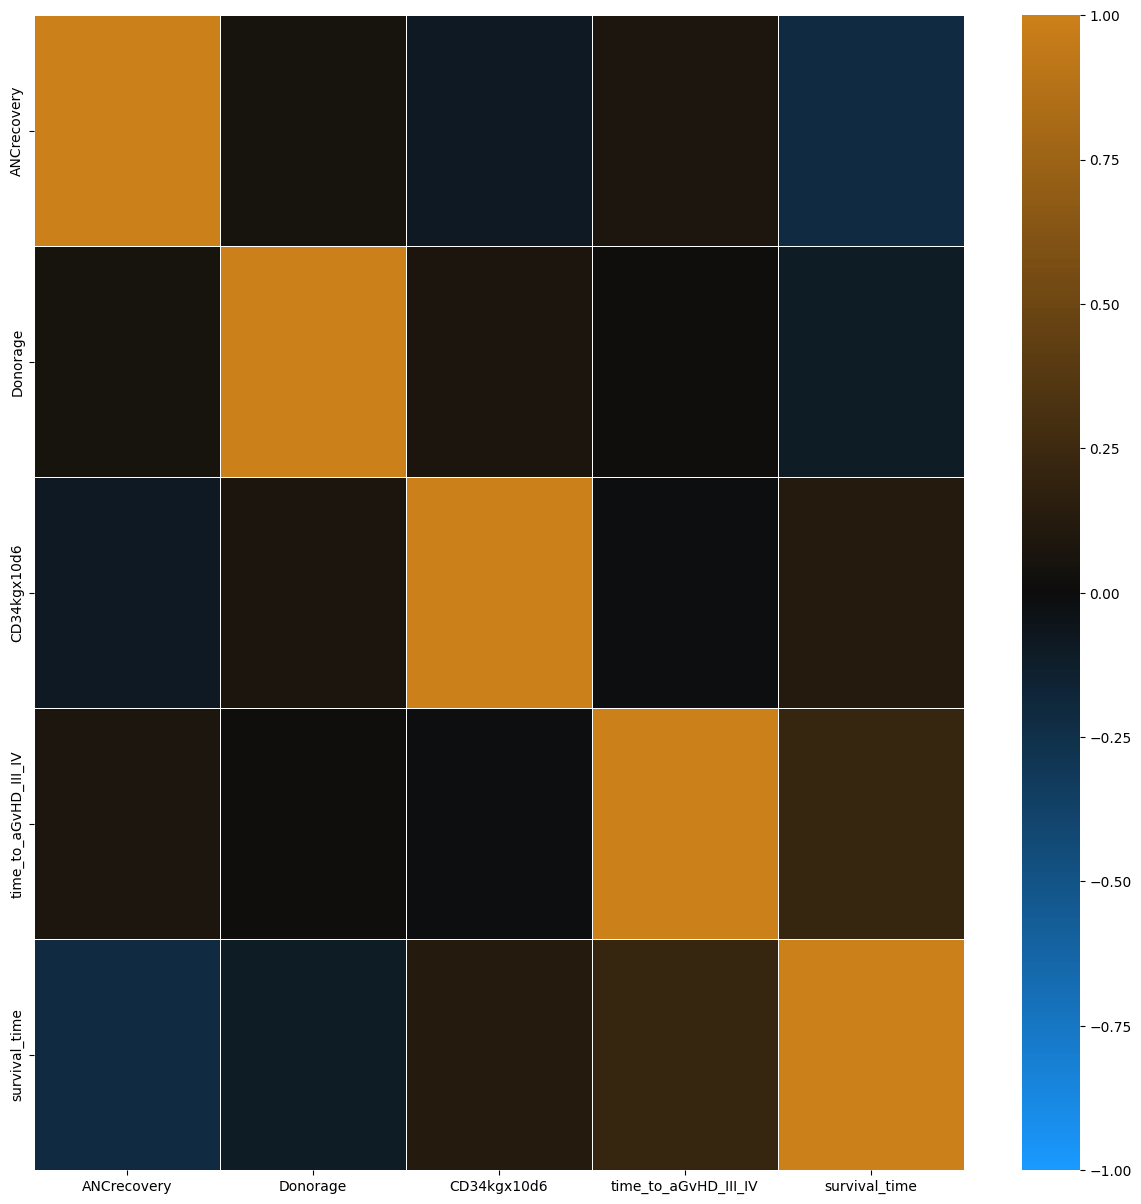

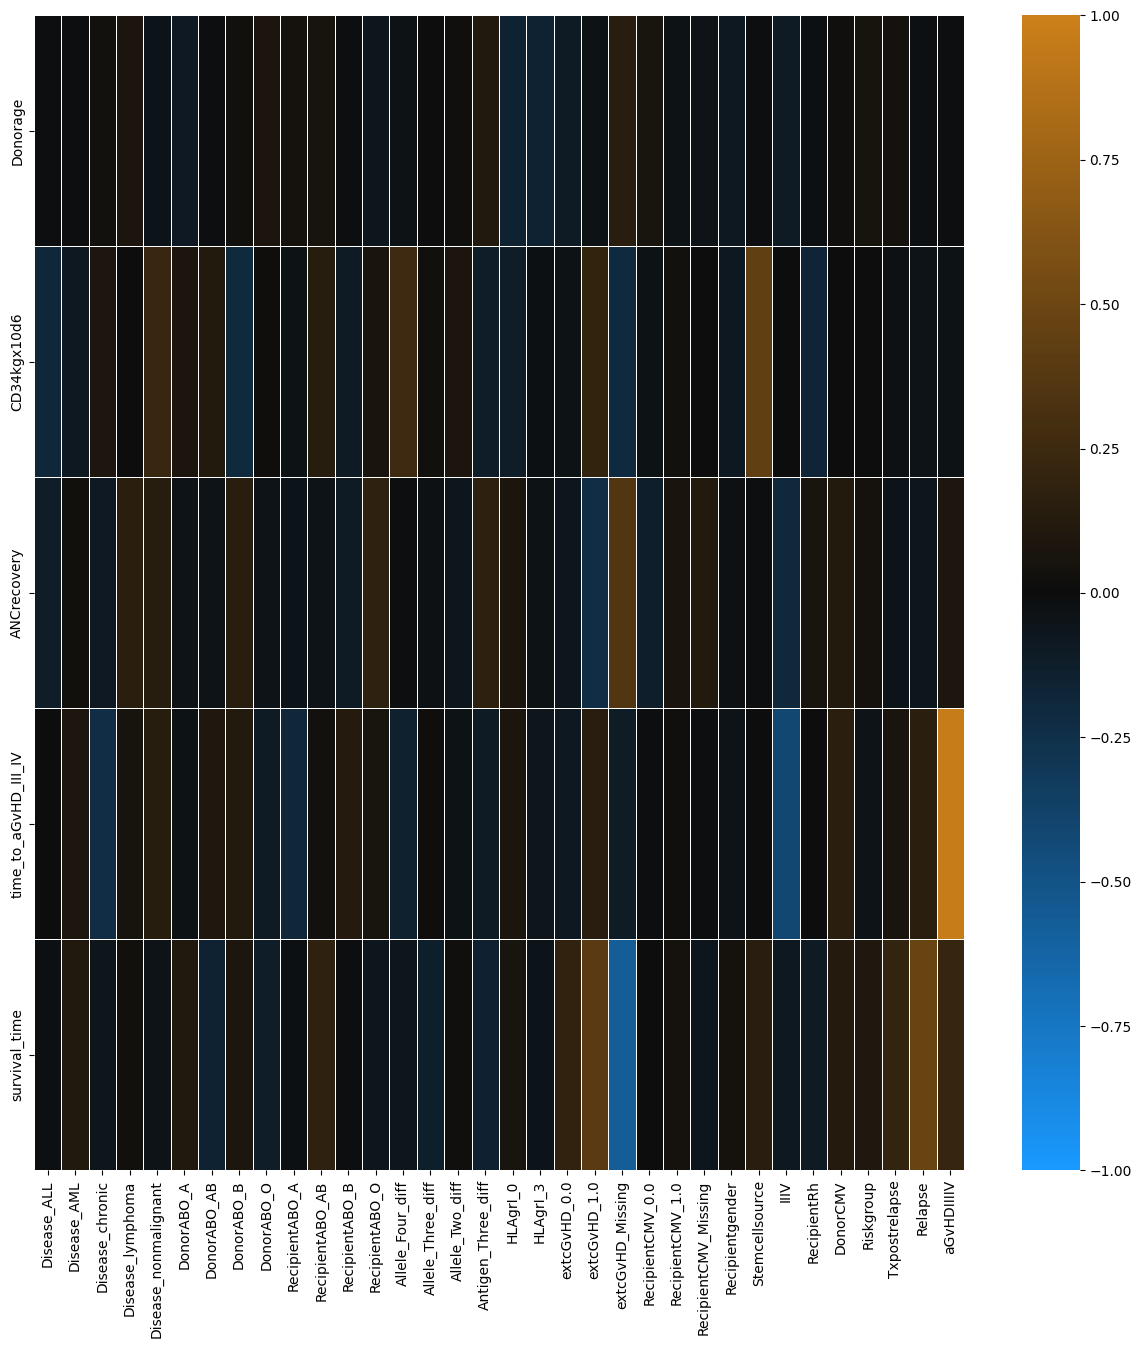

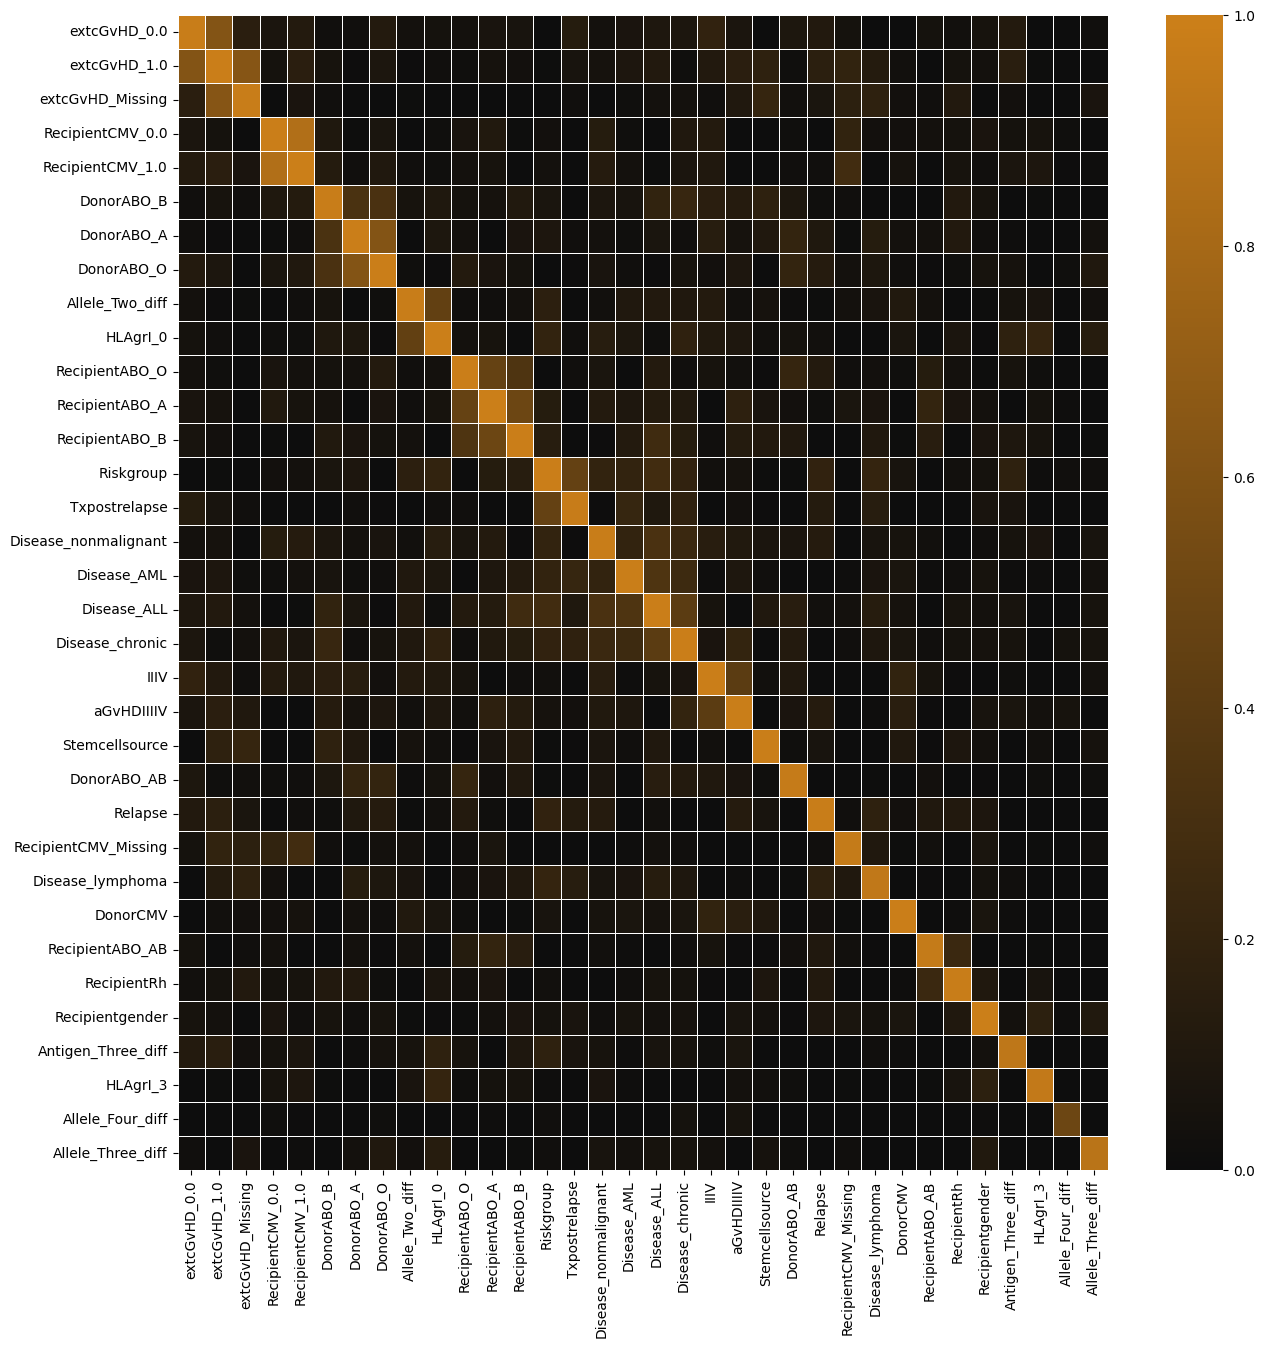

In [26]:
cont_cont_corrs_df, cont_cat_corrs_df, cat_cat_corrs_df = generate_correlation_matrices(df, continuous_features, categorical_features)

In [27]:
def get_feature_description_with_feature_name(feature_name: str) -> str:
    description_df = bone_marrow_transplant_children.variables
    return description_df[description_df.name == feature_name]['description'].array[0]

In [28]:
get_feature_description_with_feature_name('survival_status')

'Survival status (0 - alive, 1 - dead)'

## Patients clustering

We normalize features before clustering the patients.

In [29]:
def normalize(df: pd.DataFrame) -> pd.DataFrame:
    binary_columns = df.columns[df.isin([0,1]).all()]

    for col in df.columns:
        if col in binary_columns:
            pass
        elif col in ['PLTrecovery', 'ANCrecovery', 'time_to_aGvHD_III_IV']:
            df[col] = df[col].replace({1000000: -1})
            df[col] = (df[col] - df[df[col] != -1][col].mean()) / df[df[col] != -1][col].std()
        else:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df
    

In [30]:
# We only want to normalize and keep survival_time and survival_time identical
df_to_normalize = df.iloc[:, :-2].astype(float)
df_normalized = normalize(df_to_normalize)
df = pd.concat([df_normalized, df[['survival_time', 'survival_status']]], axis=1)

In [31]:
df

,Disease_ALL,Disease_AML,Disease_chronic,Disease_lymphoma,Disease_nonmalignant,DonorABO_A,DonorABO_AB,DonorABO_B,DonorABO_O,RecipientABO_A,RecipientABO_AB,RecipientABO_B,RecipientABO_O,Allele_Four_diff,Allele_Three_diff,Allele_Two_diff,Antigen_Three_diff,HLAgrI_0,HLAgrI_3,extcGvHD_0.0,extcGvHD_1.0,extcGvHD_Missing,RecipientCMV_0.0,RecipientCMV_1.0,RecipientCMV_Missing,Recipientgender,Stemcellsource,Donorage,IIIV,RecipientRh,DonorCMV,Riskgroup,Txpostrelapse,Recipientageint,Relapse,aGvHDIIIIV,CD34kgx10d6,ANCrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,-1.294501,1.0,1.0,1.0,1.0,0.0,-0.251835,0.0,0.0,-0.482851,1.285722,0.032880,999,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.231400,1.0,1.0,0.0,0.0,0.0,-1.456559,1.0,1.0,-0.765050,0.254362,-1.323400,163,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.855500,1.0,1.0,0.0,0.0,0.0,-0.251835,1.0,1.0,-0.405508,2.660867,-1.323400,435,1
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.781389,1.0,1.0,1.0,0.0,0.0,0.952889,0.0,0.0,-0.791179,2.660867,-0.501413,53,1
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.002255,0.0,0.0,0.0,1.0,0.0,-1.456559,0.0,1.0,4.183877,-0.433211,-1.323400,2043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.528651,0.0,1.0,1.0,1.0,0.0,-0.251835,0.0,1.0,0.079456,-5.590007,-1.323400,6,1
182,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.521565,1.0,0.0,1.0,1.0,1.0,0.952889,1.0,0.0,-0.077321,-0.089424,-0.624711,385,1
183,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.286402,0.0,1.0,0.0,1.0,0.0,0.952889,0.0,1.0,-0.750417,-1.120784,-1.323400,634,1
184,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.738073,1.0,1.0,1.0,0.0,0.0,0.952889,0.0,1.0,-0.427457,0.254362,-1.323400,1895,0


To get the optimal number of clusters we use the silhouette score : we choose the number of clusters which maximizes it.

In [32]:
features = df.iloc[:, :-2]

silhouette_scores = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=10).fit(features)
    labels = kmeans.labels_
    silhouette_scores.append(sklearn.metrics.silhouette_score(features, labels))

In [33]:
optimal_number_of_cluster = range(2, 10)[np.argmax(silhouette_scores)]

In [34]:
optimal_number_of_cluster

2

In [35]:
fig = px.line(x=range(2, 5), y=silhouette_scores)
fig.show()

In [36]:
optimal_kmeans = KMeans(n_clusters=optimal_number_of_cluster, n_init=15, random_state=10).fit(features)
labels = optimal_kmeans.labels_

In [37]:
# We add survival_time and survival_status information to features
data = np.concatenate((features, df.iloc[:, -2:]), axis=1)

In [38]:
def split_data_by_cluster_indices(data: np.ndarray, cluster_indices: List[int]) -> List[np.ndarray]:
    s = np.argsort(cluster_indices)
    data_per_clusters = np.split(data[s], np.unique(cluster_indices[s], return_index=True)[1][1:])
    return data_per_clusters

In [39]:
data_per_clusters = split_data_by_cluster_indices(np.array(data), labels)

### Clusters visualization in 3D space

We can now visualize the data of each of our 2 clusters in 3D dimension using a PCA.

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(features)

In [41]:
fig = px.scatter_3d(x=reduced_data[:, 0], y=reduced_data[:, 1], z=reduced_data[:, 2], color=labels)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Survival analysis

### a) Kaplan Meier curve

#### Custom implementation

In [42]:
import functools
import operator

In [43]:
def kaplan_meier_estimator(observation_time_steps: pd.Series, survival_status: pd.Series) -> List[float]:

    unique_time_steps = np.sort(np.array(observation_time_steps.unique()))

    hazard_rates = []
    for t in unique_time_steps:
        total_number_of_patients = len(survival_status)
        # patients_at_risk_at_time_t = total number of patients - censored_patients_before_t - dead_patients_before_t
        patient_at_risk_at_time_t = total_number_of_patients - len(survival_status[(observation_time_steps < t)])
        
        patients_that_died_at_t = len(survival_status[(observation_time_steps == t) & (survival_status == 1)])
        
        hazard_rates.append(1 - patients_that_died_at_t/patient_at_risk_at_time_t)

    kaplan_meier_estimations = []
    for t in range(len(unique_time_steps)):
        kaplan_meier_estimations.append(functools.reduce(operator.mul, hazard_rates[:t], 1))

    return kaplan_meier_estimations

In [44]:
def fill_estimations_between_observation_time_steps(kaplan_meier_estimations: List[float],
                                                    unique_sorted_observation_times: List[int]
                                                   ) -> tuple[List[float], List[int]]:
    estimations = []
    for i in range(len(unique_sorted_observation_times)):
        if i == 0:
            estimations += [1] * unique_sorted_observation_times[0]
        else : 
            estimations += [kaplan_meier_estimations[i]] * (unique_sorted_observation_times[i] - unique_sorted_observation_times[i-1])

    filled_time_steps = list(range(max(unique_sorted_observation_times)))
    return estimations, filled_time_steps


We compute the survival function for each of our 2 clusters and then plot it.

In [45]:
clusters_ts = []
clusters_kp_estimations = []

for cluster_data in data_per_clusters:
    cluster_data = pd.DataFrame(data=cluster_data, columns = df.columns)
    kaplan_meier_estimations = kaplan_meier_estimator(cluster_data['survival_time'], cluster_data['survival_status'])
    unique_sorted_time_step = np.sort(np.array(cluster_data['survival_time'].astype(int).unique()))

    filled_estimations, filled_time_steps = fill_estimations_between_observation_time_steps(kaplan_meier_estimations, unique_sorted_time_step)

    clusters_ts.append(filled_time_steps)
    clusters_kp_estimations.append(filled_estimations)

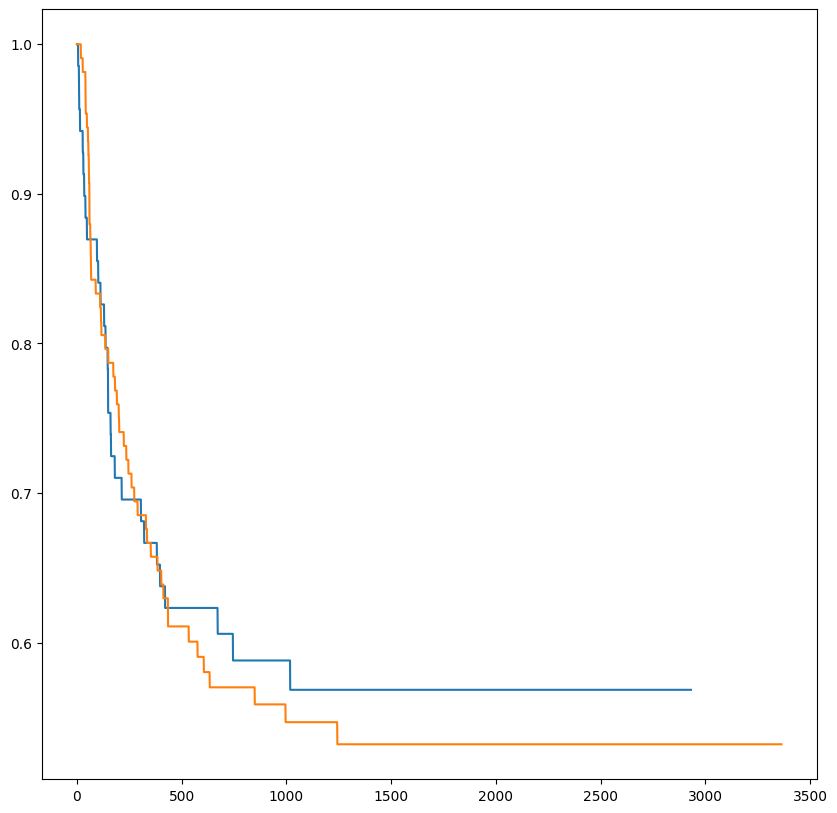

In [46]:
plt.figure(figsize=(10,10))
for i in range(len(clusters_ts)):
    plt.plot(clusters_ts[i], clusters_kp_estimations[i])

plt.show()

#### Lifelines implementation

In [47]:
from lifelines import KaplanMeierFitter

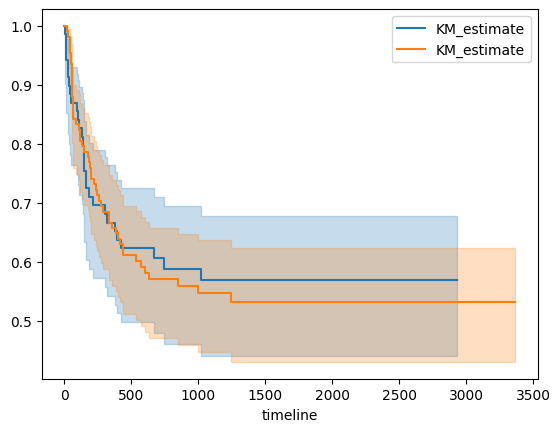

In [48]:
for cluster_data in data_per_clusters:
    cluster_data = pd.DataFrame(data=cluster_data, columns = df.columns)
    kmf = KaplanMeierFitter()
    kmf.fit(cluster_data['survival_time'], cluster_data['survival_status'])
    kmf.plot()
plt.show()

The results of the custom implementation are consistent with the lifelines implementation.

### b) COX-PH Model

In [49]:
data_per_clusters = split_data_by_cluster_indices(np.array(data), labels)

The following cell does several things:

- Since there are many features compared with the number of patients, the COX-PH model has difficulty in converging. To facilitate convergence, we select the 15 features most correlated with survival_time for each of the two patient clusters.

- Once the features have been selected, a COX-PH model is trained on the data. We then plot the parameters associated with each of the features and their respective variances.
  
- The average survival function for all patients in the cluster is then plotted.
   
- Once the model has been trained, we check that the proportional hazards hypothesis is verified for each of the features on which the model has been trained.  The p-values of the test are given for each variable in a table.

Cluster 0

Features used for cluster 0 : ['extcGvHD_0.0', 'Txpostrelapse', 'Relapse', 'CD34kgx10d6', 'ANCrecovery']


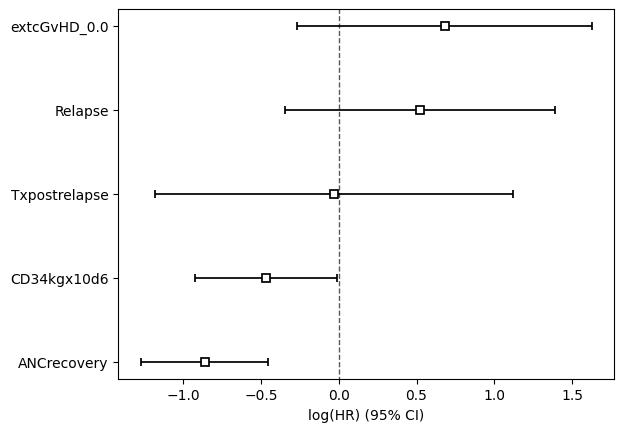

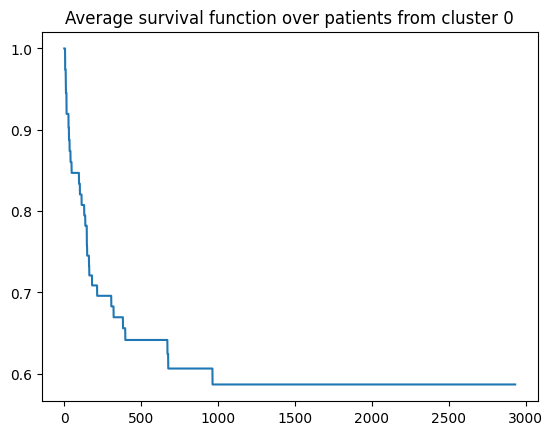

Proportional Hazard test



<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 69 total observations, 40 right-censored observations>
         test_name = proportional_hazard_test

---
               test_statistic    p  -log2(p)
ANCrecovery              0.30 0.59      0.77
CD34kgx10d6              0.16 0.69      0.53
Relapse                  3.54 0.06      4.06
Txpostrelapse            1.07 0.30      1.73
extcGvHD_0.0             7.00 0.01      6.94

Cluster 1

Features used for cluster 1 : ['RecipientABO_AB', 'extcGvHD_1.0', 'DonorCMV', 'Riskgroup', 'Relapse']


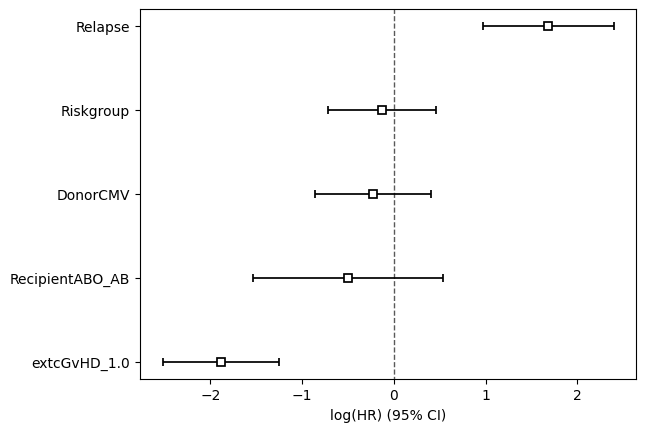

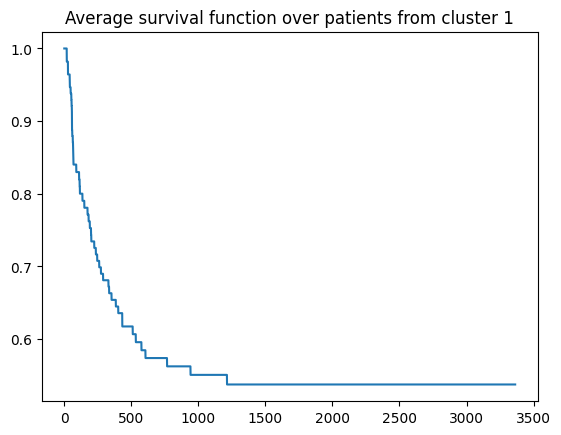

Proportional Hazard test



<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 108 total observations, 59 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic      p  -log2(p)
DonorCMV                   0.99   0.32      1.65
RecipientABO_AB            0.33   0.57      0.82
Relapse                   14.41 <0.005     12.73
Riskgroup                  0.02   0.89      0.17
extcGvHD_1.0               2.30   0.13      2.95

In [50]:
from lifelines import CoxPHFitter
from sklearn.feature_selection import SelectKBest, r_regression
from lifelines.statistics import proportional_hazard_test

for i, cluster_data in enumerate(data_per_clusters):
    print(f'Cluster {i}', end = '\n\n')
    cluster_data = pd.DataFrame(data=cluster_data, columns = df.columns)

    selector = SelectKBest(r_regression, k=5)
    selector.fit(cluster_data[cluster_data.survival_status == 1].iloc[:, :-2], cluster_data[cluster_data.survival_status == 1].survival_time)
    cols_idxs = selector.get_support(indices=True)
    features_to_use = cluster_data.iloc[:, cols_idxs]
    features_to_use = list(features_to_use.columns)
    
    print(f'Features used for cluster {i} :', features_to_use)
    
    cph = CoxPHFitter()
    cph.fit(cluster_data[features_to_use + ['survival_time', 'survival_status']], 'survival_time', 'survival_status')
    #cph.print_summary()
    cph.plot()
    plt.show()

    # Average survival function over the cluster patients
    cluster_patients_survival_function = cph.predict_survival_function(cluster_data[features_to_use + ['survival_time', 'survival_status']])
    
    average_survival_function = np.array(cluster_patients_survival_function.mean(axis=1))
    time_steps = list(cluster_patients_survival_function.index.astype(int))
    
    filled_estimations, filled_time_steps = fill_estimations_between_observation_time_steps(average_survival_function, time_steps)
    plt.plot(filled_time_steps, filled_estimations)
    plt.title(f"Average survival function over patients from cluster {i}") 
    plt.show()
    
    # Check proportional hazard assumption
    print('Proportional Hazard test', end = '\n\n')
    results = proportional_hazard_test(cph, cluster_data[features_to_use + ['survival_time', 'survival_status']], time_transform='rank')
    results.print_summary(decimals=3, model="untransformed variables")

#### Results Analysis

#### a) Parameters impact on survival function

Note that some observations on the graphs showing model weights are not significant, given the very wide confidence intervals associated with each of the model parameters. We need more data to give solid conclusions.

For the <b>cluster 1</b>, we note that : 

- When extcGvHD is 0, (i.e. extcGvHD_0.0 = 1, there is development of extensive chronic graft versus host disease), the patient's survival time is greatly reduced.

- The ANC_recovery (Time to neutrophils recovery) feature also plays an important role. The greater it is, the more it increases the patient's survival time.

- Also, the greater CD34+ cell dose per kg is (i.e feature CD34kgx10d6), the greater is patient's survival time.

For the <b>cluster 2</b>, we note that:

- We find the same behavior for the extcGvHD feature. When it is equal to 1, (i.e. extcGvHD_0.0 = 0, extcGvHD_1.0 = 1, the opposite case of cluster 1) the survival time is increased.

- It is complicated to conclude anything about the impact of the Relapse feature given that it does not verify the proportional hazard hypothesis (see next part).

#### b) Proportional hazard assumption

By setting the p-value threshold of the test for each of the variables at 0.05, we can see that the null hypothesis is refuted in none of the cases for cluster 1, which means the assumption is verified. However it is refuted for feature Relapse in cluster 2. 

We must therefore use variants of the COX-PH model such as the stratified cox model or the time varying cox model.